## 1. Load Curvature Database File

In [1]:
import sys
import os
import pandas as pd 

CURVATURE_PATH = '../src/datasets'
CURVATURE_FILE = 'Grav_ALL_200_HGM_MS.csv'
MIN_POINTS = 3
AZIMUTH_TOL = 40
DISTANCE_TOL = None

def load_curvature_file(curvature_file=CURVATURE_FILE, curvature_path=CURVATURE_PATH):
    csv_path = os.path.join(curvature_path, curvature_file)
    return pd.read_csv(csv_path)

df = load_curvature_file()
original_df = df.copy()
print df.head()

      ID        Z1        Z2         Z3            Z4            Z5  Z6  \
0  ridge  0.003922  0.479776 -49.833267  6.578691e-10 -1.371200e-09   1   
1  ridge  0.005314  0.018001 -19.639816 -4.133127e-11 -2.296009e-09   1   
2  ridge  0.005673  0.143790 -13.593872  2.065677e-10 -1.436596e-09   1   
3  ridge  0.005863  0.022067  26.082394  2.273698e-11 -1.030366e-09   1   
4  ridge  0.006028  0.095139  35.298409 -1.125376e-10 -1.182870e-09   1   

              X          Y            X2         Y2           __X        __Y  
0  356340.28125  5021729.0  356340.28125  5021729.0  356340.28125  5021729.0  
1  355714.87500  5022369.5  355714.87500  5022369.5  355714.87500  5022369.5  
2  355532.03125  5022583.5  355532.03125  5022583.5  355532.03125  5022583.5  
3  353982.12500  5022809.0  353982.12500  5022809.0  353982.12500  5022809.0  
4  353959.68750  5023028.5  353959.68750  5023028.5  353959.68750  5023028.5  


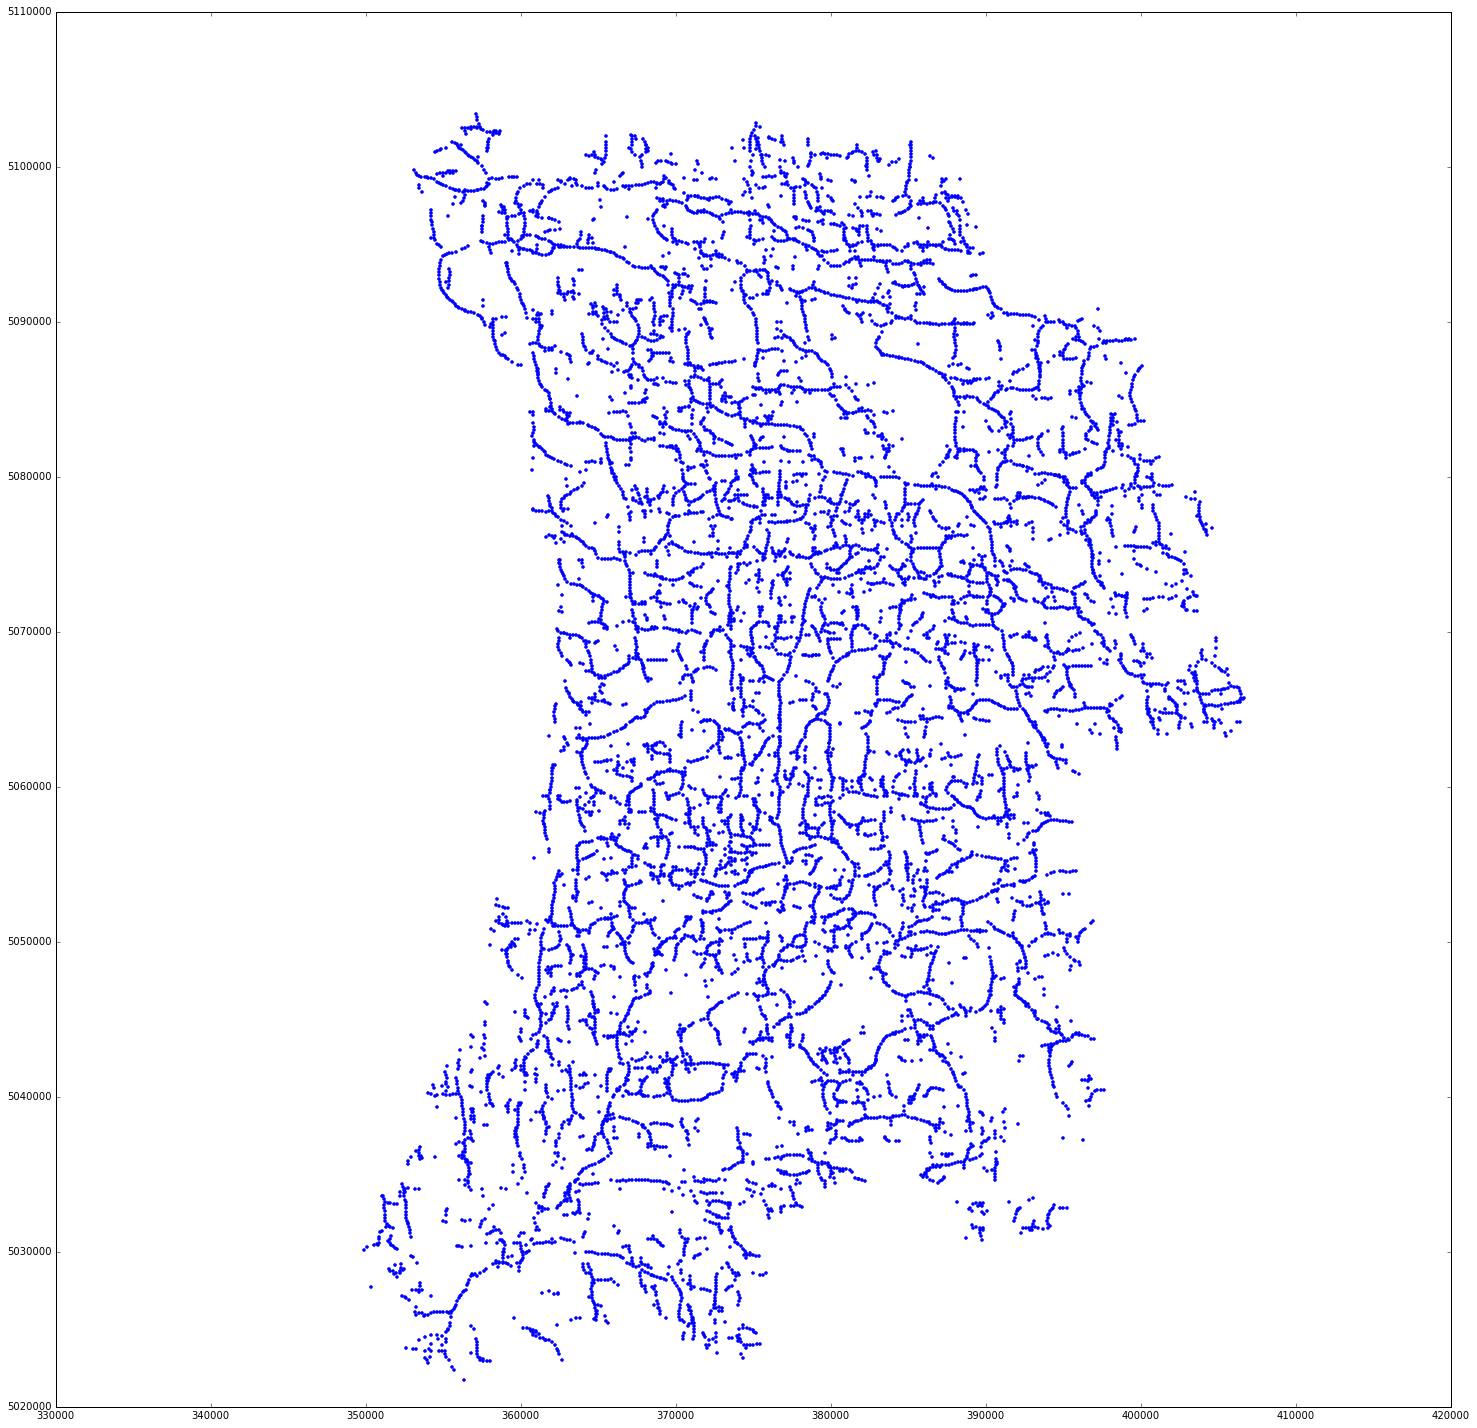

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25, 25))
plt.plot(df.X, df.Y, '.')
plt.axis('equal')
plt.show()

## 2. Group points into lines using single linkage hierarchical clustering

In [3]:
import scipy as sp
import scipy.cluster.hierarchy as hac
import numpy as np

def dist_nearest_point(points):
    dists = sp.spatial.distance.pdist(points)
    dists_matrix = sp.spatial.distance.squareform(dists)
    dists_matrix[dists_matrix == 0] = np.nan
    return np.nanmin(dists_matrix, axis = 0)

def calculate_distance_tolerance(df):
    dist_to_nearest = dist_nearest_point(df[['X', 'Y']].values)
    return np.mean(dist_to_nearest) + np.std(dist_to_nearest)

def hac_clustering(df, method, height):
    Z = hac.linkage(df[['X', 'Y']].values, method = method)
    return hac.cut_tree(Z, height = height)

def remove_small_clusters(df, channel = 'clustering', min_points = 3):
    unique, counts = np.unique(df[channel], return_counts = True)
    lines_with_points = unique[counts > (min_points - 1)]
    return df[df[channel].isin(lines_with_points)]

dist_threshold = calculate_distance_tolerance(df)
df['clustering'] = hac_clustering(df, 'single', dist_threshold)
df = remove_small_clusters(df, min_points=MIN_POINTS)

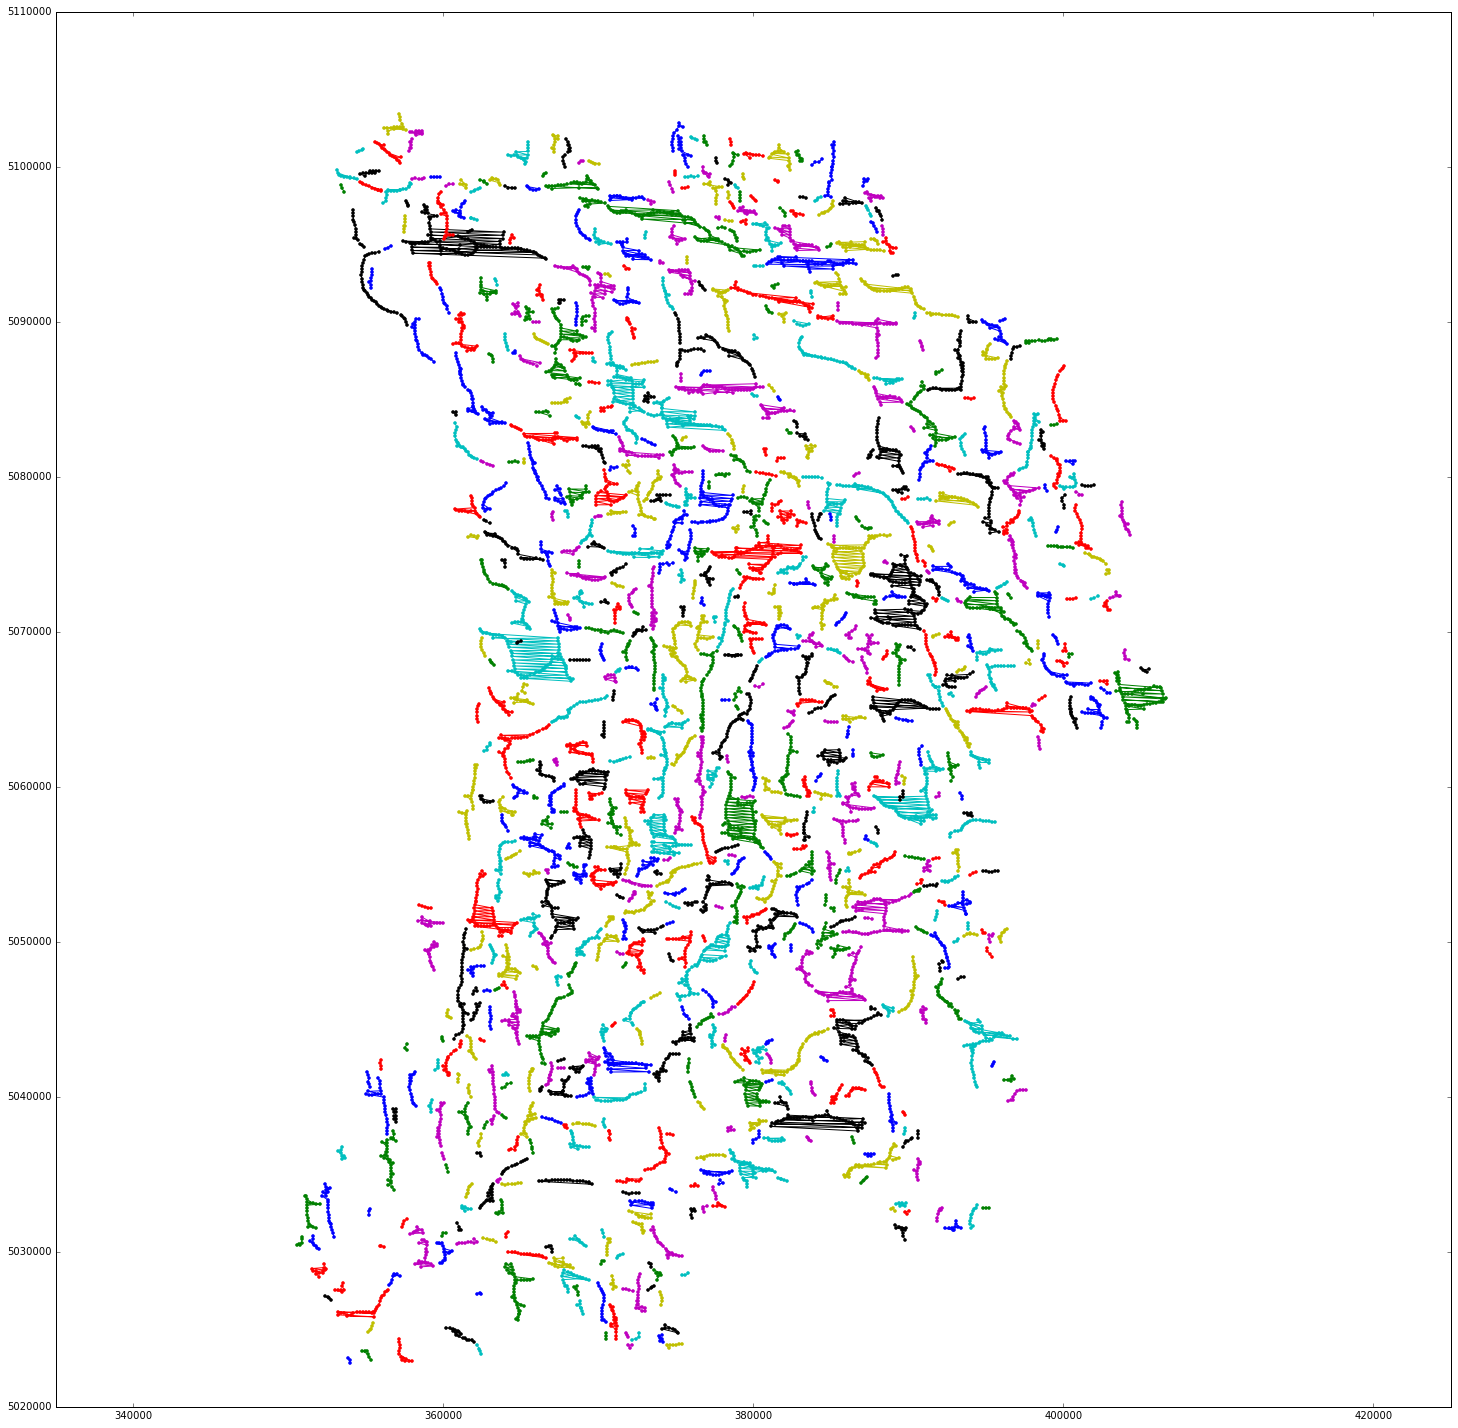

In [4]:
fig = plt.figure(figsize=(25, 25))
for clust in df.clustering.unique():
    plt.plot(df[df.clustering == clust].X, df[df.clustering == clust].Y, '.-')
plt.axis('equal')
plt.show()

## 3. Revise line groupings using graphs to optimize for longer, ordered lines

In [5]:
sys.path.insert(0, '../src')
import dijkstra as dij
pd.options.mode.chained_assignment = None

def get_farthest_point(points):
    center = np.mean(points, axis=0)
    dist_to_center = np.linalg.norm(points - center, axis = 1)
    return points.iloc[np.argmax(dist_to_center)]

def points_to_graph(points, dist_threshold):
    graph = {}
    for index, row in points.iterrows():
        points_to_check = points.copy()
        current_point = points_to_check.loc[index]
        points_to_check.drop(index, inplace = True)
        dists = np.linalg.norm(points_to_check[['X', 'Y']] - current_point[['X', 'Y']], axis = 1)
        neighbors = points_to_check.iloc[np.argsort(dists)]
        neighbors['dists'] = dists
        neighbors = neighbors[np.linalg.norm(neighbors[['X', 'Y']] - current_point[['X', 'Y']], axis = 1) < dist_threshold]
        graph[index] = neighbors[['dists']].T.to_dict('records')[0]
    return graph

def calc_azimuth(point1, point2):
    """ Returns heading in degrees clockwise from north """
    dx = float(point2[0] - point1[0])
    dy = float(point2[1] - point1[1])
    if dx > 0: theta = (np.pi*0.5) - np.arctan(dy/dx)
    elif dx < 0: theta = (np.pi*1.5) - np.arctan(dy/dx)
    elif dy > 0: theta = 0
    elif dy < 0: theta = np.pi
    else:
        theta = 99999
    return np.degrees(theta)

def azimuth_difference(azimuth1, azimuth2):
    """ Returns difference of two azimuths in degrees """
    azimuth_diff = np.absolute(azimuth1 - azimuth2)
    if azimuth_diff > 180: azimuth_diff = 360 - azimuth_diff
    return azimuth_diff

def select_optimal_path(paths, points):
    paths = sorted(paths, key = len, reverse = True) # Look at longest path first
    azimuth_check = False
    while (azimuth_check == False):
        for path in paths:
            if len(path) > 0:
                azimuth_deviation = []
                for i in range(0, len(path) - 2):
                    az1 = calc_azimuth(points.loc[path[i]][['X', 'Y']], points.loc[path[i + 1]][['X', 'Y']])
                    az2 = calc_azimuth(points.loc[path[i + 1]][['X', 'Y']], points.loc[path[i + 2]][['X', 'Y']])
                    azimuth_deviation.append(azimuth_difference(az1, az2))
                if all(az < AZIMUTH_TOL for az in azimuth_deviation):
                    azimuth_check = True
                    break
            else:
                azimuth_check = True
                break
    return path

def update_points(points, points_assigned, path, line):
    for id_ in path:
        next_row = points_assigned[pd.isnull(points_assigned.X)].index.min()
        next_point = points.loc[id_][['X', 'Y']]
        next_point['line'] = line
        next_point['id'] = points.loc[id_].name
        points_assigned.loc[next_row] = next_point
        points.drop(id_, inplace = True)
    return points, points_assigned

def assign_lines(points, dist_threshold):
    all_points = points.copy()
    points_assigned = pd.DataFrame(index = range(points.shape[0]), columns = points.columns, dtype='float')
    points_assigned['line'] = np.nan
    points_assigned['id'] = np.nan
    min_distance = dist_nearest_point(points).min()
    line = 1
    while (min_distance < dist_threshold):
        start_point = get_farthest_point(points)
        graph = points_to_graph(points, dist_threshold)
        ### TODO: Check paths starting with farthest node and working back
        paths = [dij.shortestPath(graph, start_point.name, x) for x in points.index][1:]
        path = select_optimal_path(paths, points)
        points, points_assigned = update_points(points, points_assigned, path, line)
        if (start_point.name in points.index): points.drop(start_point.name, inplace = True)
        line = line + 1
        min_distance = dist_nearest_point(points).min()
    points_assigned.dropna(axis=0, how='any', inplace=True)
    points_assigned[['line', 'id']] = points_assigned[['line', 'id']].astype('int')
    return points_assigned

def clusters_to_lines(df, dist_threshold):
    if DISTANCE_TOL:
        dist_threshold = DISTANCE_TOL
    else:
        dist_threshold = dist_threshold * 1 # Tuning parameter to force lines to go through more points
    df['Line'] = 0
    df['FID'] = 0
    i = 1
    for cluster in df.clustering.unique():
        cluster_points = df[df.clustering == cluster][['X', 'Y']]
        lines = assign_lines(cluster_points, dist_threshold)
        lines.line = lines.line + df.Line.max()
        for id_ in lines.id:
            df.loc[id_, 'Line'] = int(lines[lines.id == id_].line)
            df.loc[id_, 'FID'] = i
            i = i + 1
    return df

df = clusters_to_lines(df, dist_threshold)

/home/nathens/anaconda2/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/home/nathens/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


In [44]:
df = df[df.Line > 0]
df = df.sort_values(['FID'])
df = remove_small_clusters(df, 'Line', min_points = 4)
for i, line_number in enumerate(df.Line.unique()):
    df.loc[df.Line == line_number, 'Line'] = i + 1
df = df.sort_values(['Line', 'FID'])

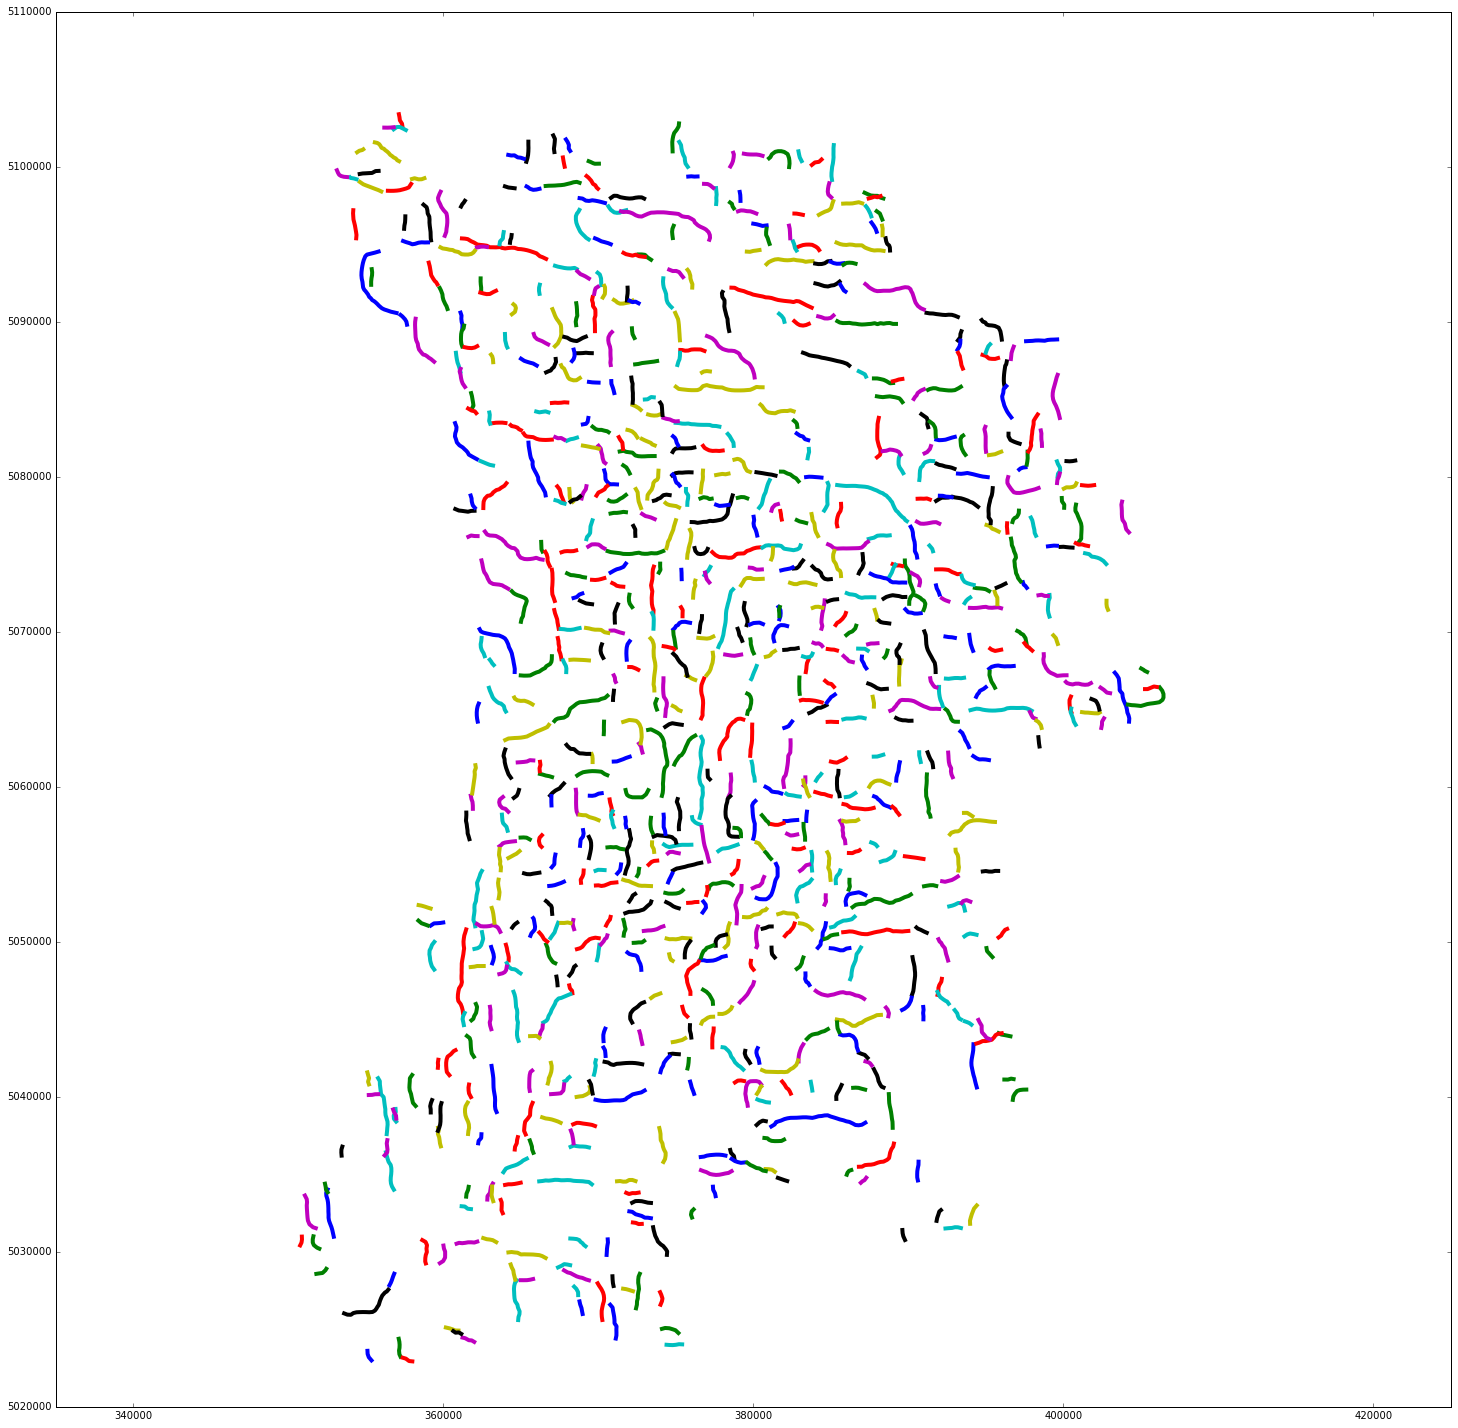

In [64]:
fig = plt.figure(figsize=(25, 25))
#plt.plot(original_df.X, original_df.Y, 'k.')
for line in df.Line.unique():
    points = df[df.Line == line][['X', 'Y']]
    plt.plot(points.X, points.Y, '-', linewidth=4)
plt.axis('equal')
plt.show()

## 4. Save the dataframe with the original columns and new line numbers

In [63]:
columns = list(original_df.columns)
columns.append('Line')
df = df[columns]
df.to_csv(CURVATURE_FILE + '_LINES.csv', index=False)